# Download Library

In [ ]:
!pip install pyvi
!pip install nltk
!pip install demoji
!pip install gensim
!pip install joblib

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Library

In [ ]:
import requests
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from google.colab import files
import re
from pyvi import ViTokenizer, ViPosTagger
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from gensim.models import FastText
from gensim.utils import simple_preprocess
from gensim.test.utils import get_tmpfile
from wordcloud import WordCloud
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import demoji
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
folder = ('/content/gdrive/My Drive/NLP/sentiment_analysis')

Mounted at /content/gdrive


# I. Crawling data from Tiki bookstore:  [Link](https://tiki.vn/nha-sach-tiki/c8322)

##1. Set User Agent

In [ ]:
HEADERS = {'User-Agent':
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'}

##2. Init file csv

In [ ]:
filename = "/data.csv"
header = ['product_id', 'customer_id', 'customer_name', 'product_title', 'description', 'satisfaction', 'review', 'status', 'is_photo', 'thank_count', 'comment_count','rating', 'images']
df = pd.DataFrame(columns=header)
df.to_csv(folder + filename, index=True, encoding='utf-8')

##3. Start to craw Data

In [ ]:
pages = list(range(1, 51))
review_pages = list(range(1, 5))
REVIEW_URL = "https://tiki.vn/api/v2/reviews"


for page in pages:
    # Select product_ids
    print(f'Lấy dữ liệu của page {page}')
    res = requests.get(f'https://tiki.vn/api/personalish/v1/blocks/listings?limit=40&aggregations=2&version=home-persionalized&trackity_id=45c9c1d2-e88d-40fe-dba7-04e106f1c71a&category=8322&page={page}&urlKey=nha-sach-tiki', headers=HEADERS)
    data = res.json()['data']
    product_ids = [product['id'] for product in data]

    # Use each product_id in product_ids to extract review data
    for product_id in product_ids:
        res = requests.get(f'https://tiki.vn/api/v2/products/{product_id}?version=3', headers=HEADERS)
        data = res.json()
        product_title= data['name']
        description = data['description']
        for review_page in review_pages:
            print(f'Lấy review_page {review_page} của sản phẩm {product_id}')
            try:
                res = requests.get(REVIEW_URL, headers=HEADERS, params= {
                    "page": review_page,
                    "product_id": product_id,
                    "include": "comments,contribute_info,attribute_vote_summary",
                    "sort": "score desc,id desc,stars all"
                })
                data = list(res.json()['data'])

                new_data_list = []
                for item in data:
                    new_item = {
                        "product_id": product_id,
                        "customer_id": item['customer_id'],
                        "customer_name": item["created_by"]["name"],
                        "product_title": product_title,
                        "description": description,
                        "satisfaction": item["title"],
                        "review": item["content"],
                        "status": item["status"],
                        "is_photo": item["is_photo"],
                        "thank_count": item["thank_count"],
                        "comment_count": item["comment_count"],
                        "rating": item["rating"],
                        "images": len(item["images"])
                    }
                    new_item['review'] = " ".join(str(new_item['review']).strip().split(" ")).replace('"', '')
                    new_data_list.append(new_item)

                with open(folder + filename, 'a', newline='', encoding='utf-8') as file:
                    writer = csv.DictWriter(file, fieldnames=header)
                    for row in new_data_list:
                        writer.writerow(row)
            except:
                continue

# Clean line break
data = []
with open(folder + filename, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        # Xử lý các hàng bị xuống dòng
        cleaned_row = [cell.strip().replace('\n', '') for cell in row]
        data.append(cleaned_row)

# Ghi dữ liệu đã xử lý vào file CSV
with open(folder + filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(data)


##4. Download data after crawling

In [ ]:
files.download(folder + filename)

#II. Exploring and Processing Text Data


##1. Load data

In [ ]:
df = pd.read_excel(folder + '/tiki.xlsx')
df.head(5)

,product_id,customer_id,customer_name,product_title,description,satisfaction,review,status,is_photo,thank_count,comment_count,rating,images
0,271391596,1645829,Nguyễn Đức Tuân,Lý Thuyết Trò Chơi,<p>TÁC GIẢ: Trần Phách Hàm</p><p>Dịch giả: Vu ...,Không hài lòng,"Quyển sách này thật sự tồi tệ, kiến thức nông ...",approved,False,1,1,2,0
1,271391596,18836589,Trần Hữu Tín,Lý Thuyết Trò Chơi,<p>TÁC GIẢ: Trần Phách Hàm</p><p>Dịch giả: Vu ...,Cực kì hài lòng,"Hình thức OK, giá bán thấp hơn so với giá in t...",approved,True,0,0,5,3
2,271391596,9056218,Lê Kiên Quyết,Lý Thuyết Trò Chơi,<p>TÁC GIẢ: Trần Phách Hàm</p><p>Dịch giả: Vu ...,Cực kì hài lòng,Nội dung rất bổ ích,approved,True,0,0,5,1
3,271391596,29571556,Anh An,Lý Thuyết Trò Chơi,<p>TÁC GIẢ: Trần Phách Hàm</p><p>Dịch giả: Vu ...,Bình thường,"Sách bị nhăn,gãy gáy-shop giao hàng chú ý hơn nhé",approved,False,1,1,3,0
4,271391596,8774273,Phạm quang Quang,Lý Thuyết Trò Chơi,<p>TÁC GIẢ: Trần Phách Hàm</p><p>Dịch giả: Vu ...,Cực kì hài lòng,"Bìa đẹp, giá tốt",approved,True,0,0,5,1


###Shape of data

In [ ]:
df.shape

(55149, 13)

##2. Drop unnecessary variables

In [ ]:
df = df[['review', 'rating']]
df.head()

,review,rating
0,"Quyển sách này thật sự tồi tệ, kiến thức nông ...",2
1,"Hình thức OK, giá bán thấp hơn so với giá in t...",5
2,Nội dung rất bổ ích,5
3,"Sách bị nhăn,gãy gáy-shop giao hàng chú ý hơn nhé",3
4,"Bìa đẹp, giá tốt",5


##3. Missing data processing

In [ ]:
# Check missing value
print('Số lượng missing data ở từng cột trong bô dữ liệu')
df.isnull().sum()

Số lượng missing data ở từng cột trong bô dữ liệu


review    18696
rating        0
dtype: int64

In [ ]:
# Check missing value after processing
df = df.dropna()
print('Số lượng missing data ở từng cột trong bô dữ liệu sau khi được xử lý')
df.isnull().sum()

Số lượng missing data ở từng cột trong bô dữ liệu sau khi được xử lý


review    0
rating    0
dtype: int64

##4. Check Target variable

In [ ]:
# Check value of 'rating'
df['rating'].unique()


array([2, 5, 3, 4, 1])

In [ ]:
# Create a new target variable
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x in [4, 5] else 'negative')
df

,review,rating,sentiment
0,"Quyển sách này thật sự tồi tệ, kiến thức nông ...",2,negative
1,"Hình thức OK, giá bán thấp hơn so với giá in t...",5,positive
2,Nội dung rất bổ ích,5,positive
3,"Sách bị nhăn,gãy gáy-shop giao hàng chú ý hơn nhé",3,negative
4,"Bìa đẹp, giá tốt",5,positive
...,...,...,...
55144,sản phẩm tốt đóng gói tạm được nhưng không ảnh...,5,positive
55145,"lần đầu mua tiki mà giao nhanh gia,một ngày là...",5,positive
55146,siaownsks hình ảnh chỉ mang tính chất minh họa,5,positive
55147,"Hình bìa xuất sắc, phối màu đẹp quá trời",5,positive


In [ ]:
review = df['review']
review

0        Quyển sách này thật sự tồi tệ, kiến thức nông ...
1        Hình thức OK, giá bán thấp hơn so với giá in t...
2                                      Nội dung rất bổ ích
3        Sách bị nhăn,gãy gáy-shop giao hàng chú ý hơn nhé
4                                         Bìa đẹp, giá tốt
                               ...                        
55144    sản phẩm tốt đóng gói tạm được nhưng không ảnh...
55145    lần đầu mua tiki mà giao nhanh gia,một ngày là...
55146       siaownsks hình ảnh chỉ mang tính chất minh họa
55147             Hình bìa xuất sắc, phối màu đẹp quá trời
55148    Hài lòng về vấn đề giao hàng đợt này của Fahas...
Name: review, Length: 36453, dtype: object

##5. Lowercase

In [ ]:
# Convert to lowercase
print('Convert to lowercase')
review = review.str.lower()
review.head()

Convert to lowercase


0    quyển sách này thật sự tồi tệ, kiến thức nông ...
1    hình thức ok, giá bán thấp hơn so với giá in t...
2                                  nội dung rất bổ ích
3    sách bị nhăn,gãy gáy-shop giao hàng chú ý hơn nhé
4                                     bìa đẹp, giá tốt
Name: review, dtype: object

## 6. Remove Punctuation

In [ ]:
# Remove punctuation
print('Remove punctuation')
review = review.str.replace('[^\w\s]',' ', regex=True)
review.head()

Remove punctuation


0    quyển sách này thật sự tồi tệ  kiến thức nông ...
1    hình thức ok  giá bán thấp hơn so với giá in t...
2                                  nội dung rất bổ ích
3    sách bị nhăn gãy gáy shop giao hàng chú ý hơn nhé
4                                     bìa đẹp  giá tốt
Name: review, dtype: object

## 7. Remove Stop Words

In [ ]:
def remove_stopwords(text):
    with open(folder + '/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
      stop_words = [word.strip() for word in file.readlines()]
    if isinstance(text, str):  #  Check if text is string
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''  # Returns empty string if not a string

print('Remove Stop Words')
review = review.apply(remove_stopwords)
review

Remove Stop Words


0        quyển sách tồi tệ kiến thức nông cạn hời hợt v...
1                             hình thức ok giá giá in sách
2                                          nội dung bổ ích
3                         sách nhăn gãy gáy shop giao hàng
4                                              bìa đẹp giá
                               ...                        
55144    sản phẩm đóng gói tạm ảnh hưởng sách shipper v...
55145              đầu mua tiki giao gia r sp đệpk lắm nha
55146                     siaownsks hình ảnh chất minh họa
55147                  hình bìa xuất sắc phối màu đẹp trời
55148    hài vấn đề giao hàng đợt fahasa đơn giao hôm m...
Name: review, Length: 36453, dtype: object

## 8. Remove word not in list

In [ ]:
# Function to remove words that are not in the word list
def remove_words_not_in_list(text):
    # Read the word list from "TuDon.txt"
    with open(folder + '/TuDon.txt', 'r', encoding='utf-8') as file:
      word_list = file.read().splitlines()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word in word_list]
    return ' '.join(filtered_tokens)

review = review.apply(remove_words_not_in_list)
review

0        quyển sách tồi tệ kiến thức nông cạn hời hợt v...
1                             hình thức ok giá giá in sách
2                                          nội dung bổ ích
3                              sách nhăn gãy gáy giao hàng
4                                              bìa đẹp giá
                               ...                        
55144    sản phẩm đóng gói tạm ảnh hưởng sách vui vẻ gi...
55145                             đầu mua giao gia lắm nha
55146                               hình ảnh chất minh họa
55147                  hình bìa xuất sắc phối màu đẹp trời
55148    hài vấn đề giao hàng đợt đơn giao hôm mai sách...
Name: review, Length: 36453, dtype: object

## 9. Correcting Spelling and Tokenizing Text

In [ ]:
def correct_spelling(text):
    words = ViTokenizer.tokenize(text)
    corrected_words = ViPosTagger.postagging(words)
    corrected_text = ' '.join(corrected_words[0])
    return corrected_text

print('Correcting Spelling and Tokenizing Text')
review = review.apply(correct_spelling)
review.head()

Correcting Spelling and Tokenizing Text


0    quyển sách tồi_tệ kiến_thức nông_cạn hời_hợt v...
1                         hình_thức ok giá giá in sách
2                                      nội_dung bổ_ích
3                          sách nhăn gãy gáy giao hàng
4                                          bìa đẹp giá
Name: review, dtype: object

## 10. Remove Emoji

In [ ]:
# Function to remove emojis using demoji
def remove_emojis(text):
    return demoji.replace_with_desc(text)

print('Remove Emoji')
review = review.apply(remove_emojis)
review.head()

Remove Emoji


0    quyển sách tồi_tệ kiến_thức nông_cạn hời_hợt v...
1                         hình_thức ok giá giá in sách
2                                      nội_dung bổ_ích
3                          sách nhăn gãy gáy giao hàng
4                                          bìa đẹp giá
Name: review, dtype: object

##11. Data Visualization

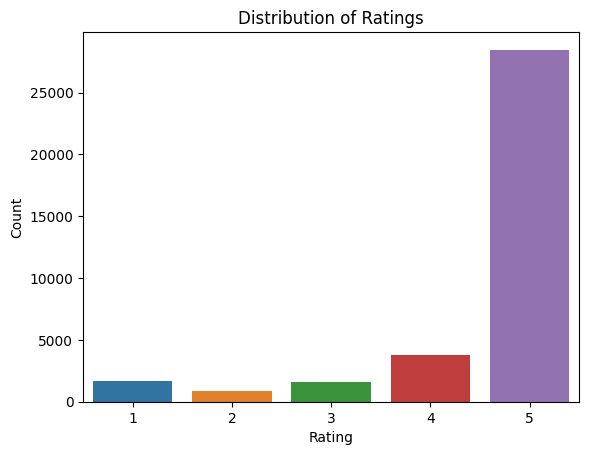

In [ ]:
sns.countplot(x='rating', data=df)

# Đặt tên cho các trục và tiêu đề cho biểu đồ
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Hiển thị biểu đồ
plt.show()

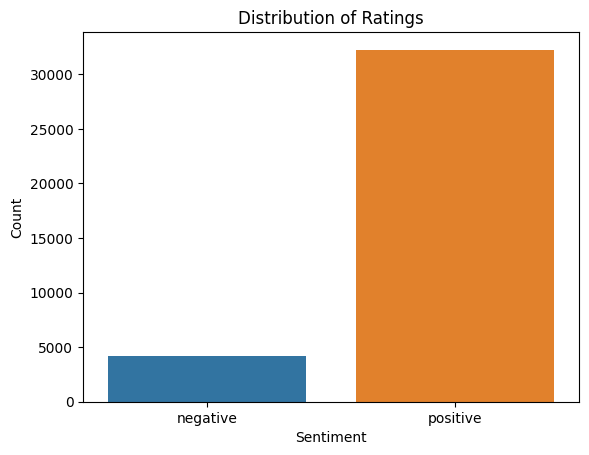

In [ ]:
sns.countplot(x='sentiment', data=df)

# Đặt tên cho các trục và tiêu đề cho biểu đồ
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Hiển thị biểu đồ
plt.show()

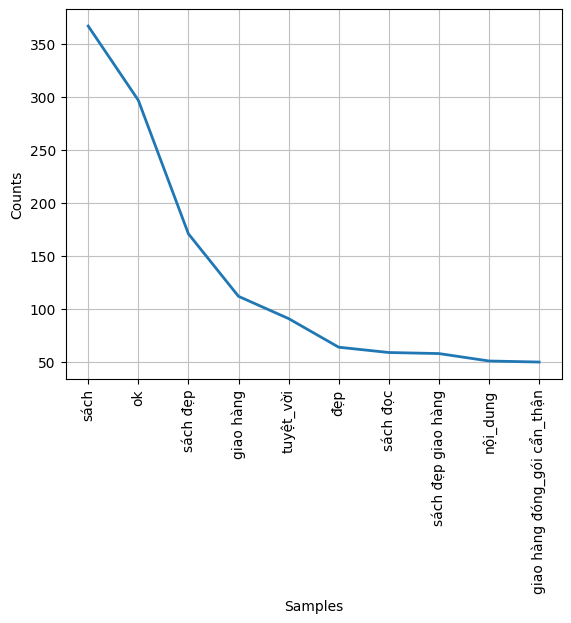

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
# Generate Frequency for all words
frequency_dist = nltk.FreqDist(review)
sorted_frequency_dist =sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
# Consider words with length greater than 1 and plot
large_words = dict([(k,v) for k,v in frequency_dist.items() if len(k)>1])
frequency_dist = nltk.FreqDist(large_words)
frequency_dist.plot(10,cumulative=False)

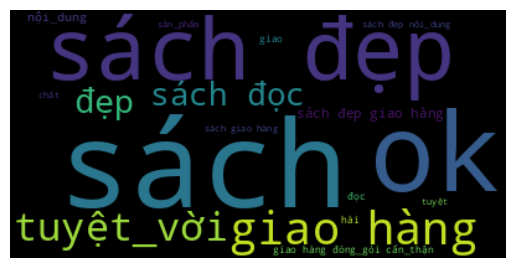

In [ ]:
#build wordcloud
wcloud = WordCloud().generate_from_frequencies(frequency_dist)
#plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#III. CONVERTING TEXT TO FEATURES

##1. Split the dataset

In [ ]:
merged_df = pd.concat([review, df['sentiment']], axis=1)
merged_df.head()

,review,sentiment
0,quyển sách tồi_tệ kiến_thức nông_cạn hời_hợt v...,negative
1,hình_thức ok giá giá in sách,positive
2,nội_dung bổ_ích,positive
3,sách nhăn gãy gáy giao hàng,negative
4,bìa đẹp giá,positive


In [ ]:
# Chia dữ liệu thành train (80%) và test (20%)
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)

In [ ]:
X_train = train['review']
y_train = train['sentiment']

X_test = test['review']
y_test = test['sentiment']

##2. Fasttext

In [ ]:
#simple preprocess
sentences = [simple_preprocess(review) for review in review]
#train model
model = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [ ]:
def vectorize_review(review):
    words = simple_preprocess(review)
    #Calculate the average vector of the words in the review
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        #Returns the average of the word vectors
        return sum(vectors) / len(vectors)
    else:
        #In case no vector is found for any word in the review
        return [0] * model.vector_size

In [ ]:
# save model
fname = get_tmpfile(folder + "/fasttext.model")
model.save(fname)
# model = FastText.load(fname)

##3. TF_IDF


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
# Fit and convert the data in the "review" column to a TF-IDF vector
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)  # Sử dụng transform() thay vì fit_transform()

# Create a new DataFrame from the TF-IDF matrix
X_train_vec = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_vec = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(X_test_vec)

      a_di_đà  a_ly  a_lô  a_sa  a_vi   am   an  an_lành  an_lạc  an_nhiên  \
0         0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
1         0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
2         0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
3         0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
4         0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
...       ...   ...   ...   ...   ...  ...  ...      ...     ...       ...   
7286      0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
7287      0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
7288      0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
7289      0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   
7290      0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0     0.0       0.0   

      ...  ứng_biến_động  ứng_cử  ứng_dụng  ứng_dụng_công  ứng_

#IV. MODEL

##1. Naive Bayes

In [ ]:
#Xây dựng mô hình Naïve Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [ ]:
# Giả sử 'nb_text' là đoạn văn bản muốn dự đoán
nb_text = ["sách tệ"]
# Chuyển đổi đoạn văn bản mới thành vector TF-IDF
new_text_vec = tfidf_vectorizer.transform(nb_text)
# Dự đoán nhãn của đoạn văn bản mới bằng mô hình Naïve Bayes đã huấn luyện
predicted_label_nb = nb_model.predict(new_text_vec)
print("Nhãn dự đoán cho đoạn văn bản mới:", predicted_label_nb[0])

Nhãn dự đoán cho đoạn văn bản mới: negative


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


In [ ]:
# Đánh giá mô hình hình
y_pred_nb = nb_model.predict(X_test_vec)
report = classification_report(y_test, y_pred_nb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.05      0.09       825
    positive       0.89      1.00      0.94      6466

    accuracy                           0.89      7291
   macro avg       0.92      0.52      0.52      7291
weighted avg       0.90      0.89      0.85      7291



In [ ]:
# Lưu vector tfidf
joblib.dump(tfidf_vectorizer, folder + "/tfidf_vector.pkl")

['/content/gdrive/My Drive/NLP/sentiment_analysis/tfidf_vector.pkl']

In [ ]:
# Lưu mô hình Naive_Bayes_model
joblib.dump(nb_model, folder + '/Naive_Bayes_model.pkl')

['/content/gdrive/My Drive/NLP/sentiment_analysis/Naive_Bayes_model.pkl']

##2. Maxent

In [ ]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train_vec, y_train)

In [ ]:
# Giả sử 'nb_text' là đoạn văn bản muốn dự đoán
lg_text = ["quyển sách tệ"]
# Chuyển đổi đoạn văn bản mới thành vector TF-IDF
new_text_vec = tfidf_vectorizer.transform(lg_text)
# Dự đoán nhãn của đoạn văn bản mới bằng mô hình Naïve Bayes đã huấn luyện
predicted_label_lg = lg_model.predict(new_text_vec)
print("Nhãn dự đoán cho đoạn văn bản mới:", predicted_label_lg[0])

Nhãn dự đoán cho đoạn văn bản mới: negative


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
# Đánh giá mô hình hình
y_pred_lg = lg_model.predict(X_test_vec)
report_lg = classification_report(y_test, y_pred_lg)
print("Classification Report:\n", report_lg)

Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.41      0.54       825
    positive       0.93      0.99      0.96      6466

    accuracy                           0.92      7291
   macro avg       0.86      0.70      0.75      7291
weighted avg       0.91      0.92      0.91      7291



In [ ]:
# Lưu mô hình Naive_Bayes_model
joblib.dump(lg_model, folder + '/logistic_regression_model.pkl')

['/content/gdrive/My Drive/NLP/sentiment_analysis/logistic_regression_model.pkl']

##3. ANN

In [ ]:
#Prepare data for the model
X_train_ann = X_train.apply(vectorize_review)
X_test_ann = X_test.apply(vectorize_review)

In [ ]:
y_train_ann = y_train.map({'positive': 1, 'negative': 0})
y_test_ann = y_test.map({'positive': 1, 'negative': 0})

In [ ]:
#Convert to ndarray type
X_train_ann = X_train_ann.values.tolist()
y_train_ann = y_train_ann.values.tolist()
X_test_ann = X_test_ann.values.tolist()
y_test_ann = y_test_ann.values.tolist()
X_train_ann = np.asarray(X_train_ann).astype('float32')
y_train_ann = np.asarray(y_train_ann).astype('float32')
X_test_ann = np.asarray(X_test_ann).astype('float32')
y_test_ann = np.asarray(y_test_ann).astype('float32')

In [ ]:
model_dl = Sequential()
model_dl.add(Flatten())
model_dl.add(Dense(256, activation='relu'))
model_dl.add(Dense(128, activation='relu'))
model_dl.add(Dense(1, activation='sigmoid'))
model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dl.fit(x = X_train_ann, y= y_train_ann, epochs=5, batch_size=32, validation_split=0.2)
loss, accuracy = model_dl.evaluate(X_test_ann, y_test_ann)
print(f'Test Accuracy: {accuracy}')

Epoch 1/5
730/730 [==============================] - 4s 4ms/step - loss: 0.2582 - accuracy: 0.9011 - val_loss: 0.2440 - val_accuracy: 0.9028
Epoch 2/5
730/730 [==============================] - 2s 3ms/step - loss: 0.2324 - accuracy: 0.9086 - val_loss: 0.2225 - val_accuracy: 0.9146
Epoch 3/5
730/730 [==============================] - 2s 3ms/step - loss: 0.2264 - accuracy: 0.9120 - val_loss: 0.2304 - val_accuracy: 0.9126
Epoch 4/5
730/730 [==============================] - 2s 3ms/step - loss: 0.2255 - accuracy: 0.9118 - val_loss: 0.2228 - val_accuracy: 0.9151
Epoch 5/5
228/228 [==============================] - 0s 2ms/step - loss: 0.2183 - accuracy: 0.9176
Test Accuracy: 0.9175695776939392


228/228 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.40      0.53       825
         1.0       0.93      0.98      0.95      6466

    accuracy                           0.92      7291
   macro avg       0.84      0.69      0.74      7291
weighted avg       0.91      0.92      0.91      7291



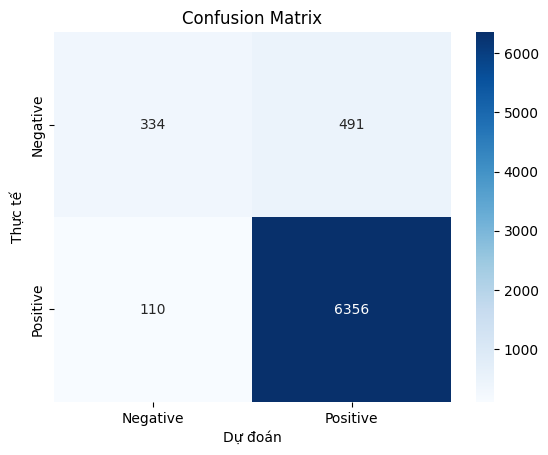

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Dự đoán nhãn trên tập kiểm tra
y_pred_ann = model_dl.predict(X_test_ann)
y_pred_ann = (y_pred_ann > 0.5).astype(int)
#Classification report
report_ann = classification_report(y_test_ann, y_pred_ann)
print("Classification Report:\n", report_ann)
# Tính confusion matrix
conf_matrix = confusion_matrix(y_test_ann, y_pred_ann)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix')
plt.show()

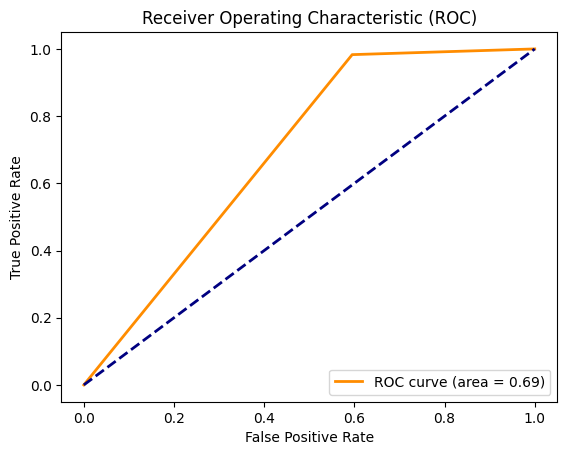

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_ann, y_pred_ann)

# Tính diện tích dưới ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Ví dụ ann
s = 'sách cũ'
s_seri = pd.Series([s])
s_vec = s_seri.apply(vectorize_review)
s_list = s_vec.values.tolist()
s_arr = np.asarray(s_list).astype('float32')
s_pred = model_dl.predict(s_arr)
s_pred = (s_pred > 0.5).astype(int)
if s_pred == 0:
  print(f'{s} -> Negative')
else:
  print(f'{s} -> Positive')

1/1 [==============================] - 0s 60ms/step
sách cũ -> Negative


In [ ]:
# Lưu mô hình
model_dl.save(folder + '/ANN.h5')